# Test Saved Bird Detection Model

In [1]:
import os
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import transforms as T
from na_birds_dataset import NABirdsDataset
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [47]:
proj_dir = os.path.join('/home/mark', 'birdcam')

data_dir = os.path.join('/media/nvme2', 'nabirds')

sample_img_dir = os.path.join('/media/nvme2', 'birdcam')

In [23]:
num_images = 25
seed = 77

In [51]:
ds = NABirdsDataset(root=data_dir, transforms=get_transforms())

In [53]:
len(ds.imgs)

48562

### Define dataset info from training dataset

In [48]:
def get_transforms():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

def get_dataset(path, num_images, seed):
    ds = NABirdsDataset(root=path, transforms=get_transforms())
    num_classes = ds.num_classes
    classes = ds.classes
    torch.manual_seed(seed)
    indices = torch.randint(len(ds), (num_images,))
    ds_sample = torch.utils.data.Subset(ds, indices)
    return ds_sample, classes, num_classes

Get number of classes for dataset

In [25]:
_, classes, num_classes = get_dataset(data_dir, 16, 77)

### Define custom dataset for unlabelled images

In [27]:
class SampleImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        paths = []
        for file in os.listdir(img_dir):
            paths.append(os.path.join(img_dir, file))
        self.img_list = paths

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        self.img_path = self.img_list[index]
        self.img = Image.open(self.img_path)

        transform = T.ComposeInputOnly([
                    T.ToTensorInputOnly()
                    ])

        i = transform(self.img)
        return i

ds = SampleImageDataset(sample_img_dir)
    
torch.manual_seed(seed)
indices = torch.randint(len(ds), (num_images,))

sample_img_ds = torch.utils.data.Subset(ds, indices)

### Load Saved Model

In [28]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [29]:
model = 'fasterrcnn_resnet50_fpn'
device = 'cuda'
model_path = '../na_birds_detector/checkpoints/fasterrcnn_resnet50_fpn/checkpoint.pth'

In [30]:
model = torchvision.models.detection.__dict__[model](pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

training_checkpoint = torch.load(model_path)
model_checkpoint = training_checkpoint['model']

model.load_state_dict(model_checkpoint)

<All keys matched successfully>

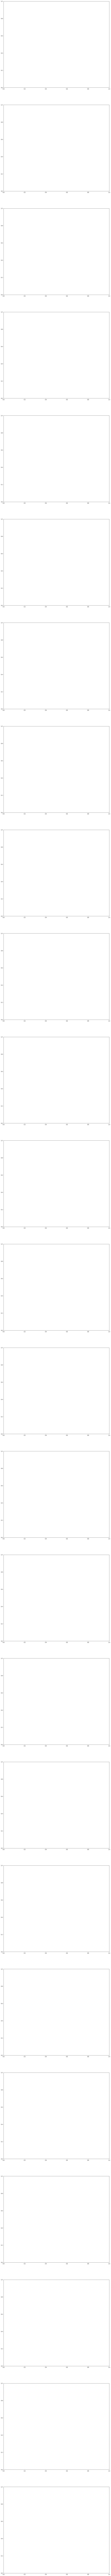

In [32]:
figure = plt.figure(figsize=(16, 16*num_images))

for i, img in enumerate(sample_img_ds):
            
    figure.add_subplot(num_images, 1, i+1)

    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

#     pred_labels = prediction[0]['labels'].cpu()
#     pred_label = pred_labels[0]
#     pred_label_str = classes[int(pred_label)]
#     pred_scores = prediction[0]['scores'].cpu()
#     pred_score = pred_scores[0]
#     pred_boxes = prediction[0]['boxes'].cpu()
#     pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_boxes[0]
#     pred_width = pred_xmax - pred_xmin
#     pred_height = pred_ymax - pred_ymin

#     plt.title(
#         'Predicted: {} (Score: {})'.format(pred_label_str, pred_score),
#         fontsize=10
#     )
#     plt.axis('off')
#     plt.imshow(img.permute(1, 2, 0))
#     plt.gca().add_patch(
#         Rectangle(
#             (pred_xmin, pred_ymin), 
#             pred_width, 
#             pred_height,
#             fill=False,
#             edgecolor='red', 
#             linewidth=2
#         )
#     )
# plt.show()

In [33]:
prediction

[{'boxes': tensor([[1357.4990,  240.7333, 2952.1677, 2298.8591],
          [1299.3645,  203.1652, 2997.0581, 2314.6824],
          [1270.3990,  109.2388, 3082.0923, 2296.3547]], device='cuda:0'),
  'labels': tensor([533, 473, 955], device='cuda:0'),
  'scores': tensor([0.4036, 0.1480, 0.0854], device='cuda:0')}]

In [34]:
prediction[0]

{'boxes': tensor([[1357.4990,  240.7333, 2952.1677, 2298.8591],
         [1299.3645,  203.1652, 2997.0581, 2314.6824],
         [1270.3990,  109.2388, 3082.0923, 2296.3547]], device='cuda:0'),
 'labels': tensor([533, 473, 955], device='cuda:0'),
 'scores': tensor([0.4036, 0.1480, 0.0854], device='cuda:0')}

In [37]:
len(prediction[0]['boxes'][0])

4

In [39]:
for i in range(len(prediction[0]['labels'])):
    if prediction[0]['scores'][i] > 90:
        print('Label: {}, Score: {}, Box: {}'.format(
            prediction[0]['labels'][i],
            prediction[0]['scores'][i],
            prediction[0]['boxes'][i]
            )
        )
    else:
        print('Threshold not met')

Threshold not met
Threshold not met
Threshold not met


In [42]:
str(prediction[0]['scores'][0])

"tensor(0.4036, device='cuda:0')"

In [45]:
prediction[0]['scores'][0].item()

0.40358415246009827